In [1]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''
'''
For the 3 SIC obs datasets. Accumulates the daily files into yearly, saves files
Then resamples each year into weeks and saves by year
Also compute regional extents
'''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
import matplotlib.pyplot as plt, mpld3


import numpy as np
import numpy.ma as ma
import os
import xarray as xr
import glob
import datetime
import pandas as pd

# ESIO Imports

from esio import EsioData as ed
from esio import metrics

import dask
# from dask.distributed import Client

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:

# c = Client()
# c

In [3]:
cd = datetime.datetime.now()
cy = cd.year   # current year
#cd = datetime.datetime(cy, 1, 2)  # force it for checking

print('this day is ',cd, ' current year', cy)
firstfive = False
if ((cd.month == 1) & (cd.day<6)):
    firstfive = True
firstfive

E = ed.EsioData.load()
data_dir = E.obs_dir
mod_dir = E.model_dir

# Products to import
product_list = ['NSIDC_0081', 'NSIDC_0079'] # , 'NSIDC_0051']


this day is  2020-02-20 12:15:15.480093  current year 2020


In [4]:
# gather all days from a given years into one file

# Loop through each product
for c_product in product_list:
    print('Aggregating ', c_product, '...')

    out_dir = os.path.join(data_dir, c_product, 'sipn_nc_yearly')
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    for cyear in np.arange(1979,cy+1,1):
        #print(cyear)
        
        cyear_str = str(cyear)
        nc_out = os.path.join(out_dir, cyear_str+'.nc')
        # Don't update file if exits, unless current year or in first 5 days of new year
        if ((os.path.isfile(nc_out)) & (cyear<cy-1)):
            print('Year ',cyear,' is done')
            continue
        if ((os.path.isfile(nc_out)) & ((cyear==cy-1) & (not(firstfive)))):
            print('Year ',cyear,' is done')
            print('And not first few days of ',cyear+1,' so do not redo ',cyear)
            continue

        # Load in Obs
        c_files = sorted(glob.glob(E.obs[c_product]['sipn_nc']+'/*_'+cyear_str+'*.nc'))
        if len(c_files)==0:
            #print("No files found for current year")
            continue
            
        ds_year = xr.open_mfdataset(c_files, 
                                      concat_dim='time', parallel=True)

        # File nc_out is occasional size zero, not sure why
        # but it was giving a permission error when trying to overwrite the file
        # since python won't overwrite a file of size zero
        # so remove it when the file is zero, could remove it no matter what
        # but want to see when it happens
        try:
            nsz = os.path.getsize(nc_out)
            print('nc_weeks ', nc_out, ' file size is ',nsz)
            if nsz==0: 
                print('removing empty file ',nc_out)
                os.remove(nc_out)
        except os.error as e:
            print('os.error is ',e) # not a problem if file doesn't exist rewritten below anyway

        print('writing netcdf file ',nc_out)
        ds_year.to_netcdf(nc_out)
        print(cyear)
      
    # For each Product
    print("Finished ", c_product)
    print("")
    
ds_year = None

Aggregating  NSIDC_0081 ...
Year  2015  is done
Year  2016  is done
Year  2017  is done
Year  2018  is done
Year  2019  is done
And not first few days of  2020  so do not redo  2019
nc_weeks  /home/disk/sipn/nicway/data/obs/NSIDC_0081/sipn_nc_yearly/2020.nc  file size is  55728649
writing netcdf file  /home/disk/sipn/nicway/data/obs/NSIDC_0081/sipn_nc_yearly/2020.nc
2020
Finished  NSIDC_0081

Aggregating  NSIDC_0079 ...
Year  1979  is done
Year  1980  is done
Year  1981  is done
Year  1982  is done
Year  1983  is done
Year  1984  is done
Year  1985  is done
Year  1986  is done
Year  1987  is done
Year  1988  is done
Year  1989  is done
Year  1990  is done
Year  1991  is done
Year  1992  is done
Year  1993  is done
Year  1994  is done
Year  1995  is done
Year  1996  is done
Year  1997  is done
Year  1998  is done
Year  1999  is done
Year  2000  is done
Year  2001  is done
Year  2002  is done
Year  2003  is done
Year  2004  is done
Year  2005  is done
Year  2006  is done
Year  2007  is d

In [5]:
# resample in weeks but always make weeks relative to Jan 1 of year

DOW   = ['sun', 
          'mon', 
          'tue', 
          'wed', 
          'thu',  
          'fri', 
          'sat']

# this routine won't work for the years before satelite data was daily

# Loop through each product
for c_product in product_list:
    print('Aggregating into weekly means starting new each year', c_product, '...')

    for cyear in np.arange(1989,cy+1,1):
        #print(cyear)
        
        cyear_str = str(cyear)
        
        data_dir = os.path.join(E.obs_dir, c_product, 'sipn_nc_yearly') # read in daily in year lumps
        data_dir_byweek = os.path.join(E.obs_dir, c_product, 'sipn_nc_yearly_byweek') # output weekly in year lumps
        nc_daily = os.path.join(data_dir, cyear_str+'.nc')
        nc_weeks = os.path.join(data_dir_byweek, cyear_str+'_byweek.nc')
        # Don't update file if exits, unless current year or in first 5 days of new year
        if (not(os.path.isfile(nc_daily))):
#            print(nc_daily,' does not exist')
            continue
        if ((os.path.isfile(nc_weeks)) & (cyear<cy-1)):
            print('Year ',cyear,' is done')
            continue
        if ((os.path.isfile(nc_weeks)) & ((cyear==cy-1) & (not(firstfive)))):
            print('Year ',cyear,' is done')
            print('And not first few days of ',cyear+1,' so do not redo ',cyear)
            continue

        # File nc_weeks is occasional size zero, not sure why
        # but it was giving a permission error when trying to overwrite the file
        # since python won't overwrite a file of size zero
        # so remove it when the file is zero, could remove it no matter what
        # but want to see when it happens
        try:
            nsz = os.path.getsize(nc_weeks)
            print('nc_weeks ', nc_weeks, ' file size is ',nsz)
            if nsz==0: 
                print('removing empty file ',nc_weeks)
                os.remove(nc_weeks)
        except os.error as e:
            print('os.error is ',e) # not a problem if file doesn't exist rewritten below anyway

        ds_daily = xr.open_mfdataset(nc_daily,data_vars=['sic','extent','area','week'],parallel=True)
        ds_daily = ds_daily.drop('hole_mask')
#        print(ds_daily)
        
        print('first DOY', ds_daily.time.isel(time=0).values)
        firstDOWnumber=ds_daily['time.dayofweek'].isel(time=0).values
        print('first day of year', firstDOWnumber)
        wstr='w-'+DOW[firstDOWnumber]
        print(wstr)

        ds_weekly = ds_daily.resample(time=wstr).mean()
        ds_weekly = ds_weekly.isel(time=slice(0,52))
        # Add DOY
        weeks = np.arange(1,len(ds_weekly.time)+1,1)
        ds_weekly.coords['week'] = xr.DataArray(weeks, dims='time', coords={'time':ds_weekly.time})

        print('SHOULD be 7th DOY ', ds_weekly.time.isel(time=0).values)
#        print('weekly extent ', ds_weekly.extent.values)
        print('writing netcdf file for year ',cyear)
        ds_weekly.to_netcdf(nc_weeks)
      
    # For each Product
    print("Finished ", c_product)
    print("")
    
ds_weekly = None
ds_dail = None

Aggregating into weekly means starting new each year NSIDC_0081 ...
Year  2015  is done
Year  2016  is done
Year  2017  is done
Year  2018  is done
Year  2019  is done
And not first few days of  2020  so do not redo  2019
nc_weeks  /home/disk/sipn/nicway/data/obs/NSIDC_0081/sipn_nc_yearly_byweek/2020_byweek.nc  file size is  9831379
first DOY 2020-01-01T00:00:00.000000000
first day of year 2
w-tue
SHOULD be 7th DOY  2020-01-07T00:00:00.000000000
writing netcdf file for year  2020
Finished  NSIDC_0081

Aggregating into weekly means starting new each year NSIDC_0079 ...
Year  1989  is done
Year  1990  is done
Year  1991  is done
Year  1992  is done
Year  1993  is done
Year  1994  is done
Year  1995  is done
Year  1996  is done
Year  1997  is done
Year  1998  is done
Year  1999  is done
Year  2000  is done
Year  2001  is done
Year  2002  is done
Year  2003  is done
Year  2004  is done
Year  2005  is done
Year  2006  is done
Year  2007  is done
Year  2008  is done
Year  2009  is done
Year 

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [6]:
# Compute regional means starting in 1989

# Load in regional data
# Note minor -0.000004 degree differences in latitude
ds_region = xr.open_dataset(os.path.join(E.grid_dir, 'sio_2016_mask_Update.nc'))


# Loop through each product
for c_product in product_list:
#for c_product in ['NSIDC_0079']:

    print('Aggregating into regional extents', c_product, '...')
    data_dir = os.path.join(E.obs_dir, c_product, 'sipn_nc_yearly') # read in daily in year lumps
    data_dir_agg = os.path.join(E.obs_dir, c_product, 'sipn_nc_yearly_agg') # output weekly in year lumps

    for cyear in np.arange(1989,cy+1,1):
        cyear_str = str(cyear)
        
        nc_fullfield = os.path.join(data_dir, cyear_str+'.nc')
        nc_agg = os.path.join(data_dir_agg, cyear_str+'.nc')
        # Don't update file if exits, unless current year or in first 5 days of new year
        if (not(os.path.isfile(nc_fullfield))):
#            print(nc_daily,' does not exist')
            continue
        if ((os.path.isfile(nc_agg)) & (cyear<cy-1)):
            print('Year ',cyear,' is done')
            continue
        if ((os.path.isfile(nc_agg)) & ((cyear==cy-1) & (not(firstfive)))):
            print('Year ',cyear,' is done')
            print('And not first few days of ',cyear+1,' so do not redo ',cyear)
            continue

        ds_field = xr.open_mfdataset(nc_fullfield,data_vars=['sic','extent','area','week'],parallel=True)
        ds_field = ds_field.drop('hole_mask')
#        print(ds_field)

        # Calc panArctic extent
#        da_panE = metrics.calc_extent(da=ds_field.sic, region=ds_region)
        da_panE = ds_field.extent  # verified is the same
        da_panE['nregions'] = 99
        da_panE['region_names'] = 'panArctic'

        # Calc Regional extents
        da_RegE = metrics.agg_by_domain(da_grid=ds_field.sic, ds_region=ds_region)

        # Merge
        ds_out = xr.concat([da_panE, da_RegE], dim='nregions')
        ds_out.name = 'Extent'
#        print(ds_out)

        ds_out.load() # This prevents many errors in the dask graph (I don't know why)

        if (len(ds_out.time)<365):  # linear interpolate missing day in 2005
            print('fixing year with missing data')
            ds_out = ds_out.resample(time='1D').interpolate('linear')

        # # Save regridded to netcdf file
        ds_out.to_netcdf(nc_agg)
        ds_out = None # Memory clean up
        da_panE = None
        da_RegE = None
        print('Saved ', nc_agg)

    # For each Product
    print("Finished ", c_product)
    print("")
    
ds_field = None

Aggregating into regional extents NSIDC_0081 ...
Year  2015  is done
Year  2016  is done
Year  2017  is done
Year  2018  is done
Year  2019  is done
And not first few days of  2020  so do not redo  2019


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


fixing year with missing data
Saved  /home/disk/sipn/nicway/data/obs/NSIDC_0081/sipn_nc_yearly_agg/2020.nc
Finished  NSIDC_0081

Aggregating into regional extents NSIDC_0079 ...
Year  1989  is done
Year  1990  is done
Year  1991  is done
Year  1992  is done
Year  1993  is done
Year  1994  is done
Year  1995  is done
Year  1996  is done
Year  1997  is done
Year  1998  is done
Year  1999  is done
Year  2000  is done
Year  2001  is done
Year  2002  is done
Year  2003  is done
Year  2004  is done
Year  2005  is done
Year  2006  is done
Year  2007  is done
Year  2008  is done
Year  2009  is done
Year  2010  is done
Year  2011  is done
Year  2012  is done
Year  2013  is done
Year  2014  is done
Year  2015  is done
Year  2016  is done
Year  2017  is done
Year  2018  is done
Finished  NSIDC_0079



In [8]:
# gather up the regionally aggregated obs for computing extrapolation by DOY
# and computing AR1 coeff. Since doing daily, decided to 
# first smooth with a 10 day running mean, finally use a lowess fit to compute params
# for extrapolation
# note that the smooth is not for a given day across years, but across days in a row

ds_79 = None
ds_81 = None

start_year = 1990
pred_year = cy + 1

# For a given day we only use data from past years
# hence to predict the climotrendextrap and damped persistence for
# Jan 20, 2020, we'd use all Jan 20 from 1990 to 2019
# Hence as each new day's data become available, it allows us to predict 
# one year in the future, so the pred_year is one year out
#pred_year = 2018   # done already
#pred_year = 2019   # done already
#pred_year = 2020   # done already

c_product = 'NSIDC_0081'
data_dir_agg = os.path.join(E.obs_dir, c_product, 'sipn_nc_yearly_agg') # output weekly in year lumps
nc_agg = os.path.join(data_dir_agg, '*.nc')
ds_81 = xr.open_mfdataset(nc_agg)

c_product = 'NSIDC_0079'
data_dir_agg = os.path.join(E.obs_dir, c_product, 'sipn_nc_yearly_agg') # output weekly in year lumps
nc_agg = os.path.join(data_dir_agg, '*.nc')
ds_79 = xr.open_mfdataset(nc_agg)

ds_79=ds_79.sel(time=slice(str(start_year),str(pred_year-1)))  # end year just has to be way in the future
ds_81=ds_81.sel(time=slice('2015',str(pred_year-1)))  # restrict to before prediciton year, lower year not important
#print(ds_81)
#print(ds_79)

ds_all = ds_79.combine_first(ds_81)  # takes ds_79 as priority
ds_all = ds_all.sel(time=slice('1990',str(pred_year-1)))
ds_81 = None

# add year to observations dataset
year_all = [x.year for x in pd.to_datetime(ds_all.time.values)]
ds_all.coords['year'] = xr.DataArray(year_all, dims='time', coords={'time':ds_all.time})

# add doy to observational dataset
DOY = [x.timetuple().tm_yday for x in pd.to_datetime(ds_all.time.values)]
ds_all.coords['doy'] = xr.DataArray(DOY, dims='time', coords={'time':ds_all.time})
ds_rough = ds_all  # save the unsmoothed data in case we want to compare
ds_all = ds_all.rolling(time=10, min_periods=1, center=True).mean()
print(ds_all)

<xarray.Dataset>
Dimensions:       (nregions: 15, time: 11006)
Coordinates:
  * time          (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2020-02-18
  * nregions      (nregions) int64 99 2 3 4 5 6 7 8 9 10 11 12 13 14 15
    region_names  (nregions) object 'panArctic' ... 'Central Arctic'
    year          (time) int64 1990 1990 1990 1990 1990 ... 2020 2020 2020 2020
    doy           (time) int64 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
Data variables:
    Extent        (time, nregions) float64 dask.array<shape=(11006, 15), chunksize=(11006, 15)>


In [15]:
TestPlot = True
if TestPlot:

import statsmodels.api as sm

def testlowessfit(x=None, y=None, order=None):

    # lowess smooth and then fit with polynomial
    # returns fit parameters output from polyfit
    
    nonans = np.logical_or(np.isnan(x), np.isnan(y))
    x_nonans = x[~nonans]
    y_nonans = y[~nonans]
    
    if y_nonans.size == 0:
        fitparms = np.empty(order+1) * np.nan
    else: 
        sumy = np.sum(y_nonans)
        leny = 1.0*np.size(y_nonans)
        fitparms = np.zeros(order+1)
        if (sumy>0. and sumy != leny):  # had sumy < leny here but this seems more general
            # lowess will return our "smoothed" data with a y value for at every x-value
            # important for eliminating problems with outliers
            lowess = sm.nonparametric.lowess(y_nonans, x_nonans, frac=.3)  # higher frac is smoother
            
            # unpack the lowess smoothed points to their values
            lowess_y = list(zip(*lowess))[1]
            
            if (len(x_nonans)!=len(lowess_y)):
                print('error fitting! ')
                print('sumy, leny, len(x_nonans), len(lowess_y) ', sumy, leny, len(x_nonans), len(lowess_y))
            else: 
                # we can use a higher order fit safely since we smoothed
                # smoothing was much less important than the 2nd order fit
                fitparms = np.polyfit(x_nonans, lowess_y, order)
        elif (sumy==leny):
            fitparms[order] = 1.0
            
    return (fitparms)



[ 2.72847095e-04 -1.09886617e+00  1.10653869e+03]
also restrict to 0 and basevalue
cyan dots are quadratic fit to lowess smoothed data, blue star is extrapolation
0.15430573727621777


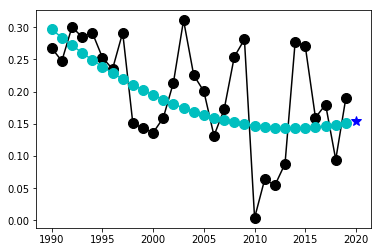

In [39]:
if TestPlot:
    pyear=2020
    pday = 80
    NR=5
    ytrain = ds_all.Extent.sel(nregions=NR).sel(time=slice('1990',str(pyear-1)))
    rough = ds_rough.Extent.sel(nregions=NR).sel(time=slice('1990',str(pyear-1)))
    ytrain = ytrain.where(ds_all['doy']==pday, drop=True).values
    rough = rough.where(ds_all['doy']==pday, drop=True).values
    cyears=np.arange(1990,pyear,1)
    
    basevalue=np.mean(ytrain[0:10])
    yn=np.where(ytrain<basevalue*0.995, ytrain, np.nan)
    
    if (np.count_nonzero(np.isnan(yn[-5:]))>1):  # >1 nan values in last 5 yrs 
        print('Too many nans in last 5 yrs, skip fit and use mean ')
        tmp=list(yn)
        newpred = np.nanmean(ytrain[-5:])  # use ytrain not yn!
    elif (np.count_nonzero(np.isnan(yn[0:14]))>10):  # >10 nan values in first 15 yrs 
        print('Too many nans in first half, use first order fit on second half')
        order = 1
        pfit = testlowessfit(cyears[15:], ytrain[15:], order)  # new method local fit to data
        #pfit = metrics._improvedLowessFit(cyears[15:], ytrain[15:], maxorder=order) 
        print(pfit)
        fitfun = np.poly1d(pfit)
        newpred = fitfun(pyear)

        # can I reconstruct it by hand (yes) it is equal to tmp = fitfun(cyears)
        tmp=cyears*pfit[0]+pfit[1]
    else:
        order = 2
        pfit = testlowessfit(cyears, ytrain, order)  # new method local fit to data
        # pfit = metrics._improvedLowessFit(cyears[:], ytrain[:], maxorder=order) 
        print(pfit)
        fitfun = np.poly1d(pfit)
        newpred = fitfun(pyear)

        # can I reconstruct it by hand (yes) it is equal to tmp = fitfun(cyears)
        tmp=cyears**2*pfit[0]+cyears*pfit[1]+pfit[2]

    print('also restrict to 0 and basevalue')
    newpred=np.where(newpred>0, newpred, 0)
    newpred=np.where(newpred<basevalue, newpred, basevalue)

    # note that the smoothing is not for a given day across years, but across days in a row
    # so black dots are not a smoothed version of green but ought to be smoother 
    # than the green

#    f = plt.figure() # only use this temporarily, must remove from py 
#    plt.plot(cyears,ytrain,marker='o',markersize=10,color='k')
    #plt.plot(cyears,rough,marker='o',markersize=8,color='r')
#    plt.plot(pyear,newpred,marker='*',markersize=10,color='b')
#    plt.plot(cyears,tmp,marker='o',markersize=10,color='c')

    #print('green dots are data without 10 day smoothing, black is with')
    print('cyan dots are quadratic fit to lowess smoothed data, blue star is extrapolation')
    print(newpred)

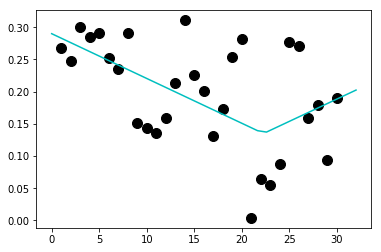

In [40]:
Testpwlf = False
if Testpwlf:  # this sounded good but was bad
    import pwlf

    x=np.arange(1,31)

    model = pwlf.PiecewiseLinFit(x, ytrain)

#    breakpoints = model.fit(2,x_c=x[0:15],
#                            y_c=np.ones(16)*max(ytrain[0:10]))  # or maybe    [0.0, 15.0, 32]
    breakpoints = model.fit(2)
    model.fit_with_breaks(breakpoints)


    xd = np.linspace(1990, 2021, 100)
    xd = np.linspace(0, 32, 35)
    yd = model.predict(xd)  # call model on new data

#    plt.plot(x, ytrain, 'o',markersize=10,color='k',label = 'data')
#    plt.plot(xd, yd, color='c', label = 'Fit')

In [12]:
# compute the fit parameters for the regionally aggregated obs
# must update each day for current pred_year
# pred_year = 2018 already did 2018, 2019 
# takes a few minutes done for 2018, 2019
c_product = 'NSIDC_0079'  # save here so all fit params are together
file_out = os.path.join(E.obs_dir, c_product, 'fitparams','fitparams_1990-'+str(pred_year-1)+'.nc') # read in daily in year lumps
print(file_out)
print('ds_all ',ds_all)
da_out = None

# these are the days we can predict 
doypred = ds_all.where(ds_all['year']==pred_year-1,drop=True).doy.values

for cdoy in doypred:

    if (cdoy==366):  # do not fit if cdoy is 366 assuming data are lacking
        continue
        
    # Select cdoy 
    thisday=ds_all.Extent.where(ds_all['doy']==cdoy, drop=True).swap_dims({'time':'year'})
    #print('thisday ',thisday.chunk({'year': -1}))
    da = metrics.ImprovedLowessFit(thisday.chunk({'year': -1}), 'year',2) # Have to rechunk so all years in one
    maxvalue = thisday.isel(year=slice(0,9)).mean(dim='year') # compute max of 1990-1999 to save with the fitparams

    da.load()  # load before saving forces calculation now
    da=da.to_dataset(dim='fitparams')
    da['maxvalue']=maxvalue

    # Move back to actual (valid_time) space
    da = da.expand_dims('time')
    da.coords['time'] = xr.DataArray([datetime.datetime(pred_year,1,1) + datetime.timedelta(days=int(x-1)) for x in [cdoy]], dims='time')
    #print(da)
    recons=pred_year**2*da.fitparams.isel(pdim=0)  +  pred_year*da.fitparams.isel(pdim=1) +  da.fitparams.isel(pdim=2)
    #print(recons.values)

    if (cdoy==1):
        da_out=da
    else:
        # Merge
        da_out = xr.concat([da_out, da], dim='time')

#        print(da_out)

if max(doypred>=365):
    # every year repreat day 365 for possibility of needing leap days, repeat is good enough
    da.coords['time'] = xr.DataArray([datetime.datetime(pred_year,1,1) + datetime.timedelta(days=int(x-1)) for x in [366]], dims='time')
    da_out = xr.concat([da_out, da], dim='time')

# Save to disk
da_out.to_netcdf(file_out)
print("Saved",file_out)

/home/disk/sipn/nicway/data/obs/NSIDC_0079/fitparams/fitparams_1990-2018.nc
ds_all  <xarray.Dataset>
Dimensions:       (nregions: 15, time: 10592)
Coordinates:
  * time          (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2018-12-31
  * nregions      (nregions) int64 99 2 3 4 5 6 7 8 9 10 11 12 13 14 15
    region_names  (nregions) object 'panArctic' ... 'Central Arctic'
    year          (time) int64 1990 1990 1990 1990 1990 ... 2018 2018 2018 2018
    doy           (time) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Data variables:
    Extent        (time, nregions) float64 dask.array<shape=(10592, 15), chunksize=(10592, 15)>


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel

Saved /home/disk/sipn/nicway/data/obs/NSIDC_0079/fitparams/fitparams_1990-2018.nc


In [23]:
# Compute and Write the climo Trend for each day of the prediction year
# must update each day for current pred_year
# pred_year = 2018 already did 2018, 2019 
#pred_year=2020

c_product = 'NSIDC_0079'  # fit params are here which is kind of dumb
file_in = os.path.join(E.obs_dir, c_product, 'fitparams','fitparams_1990-'+str(pred_year-1)+'.nc') # read in daily in year lumps

ds = xr.open_mfdataset(file_in, autoclose=True, parallel=True)

recons=pred_year**2*ds.fitparams.isel(pdim=0)  +  pred_year*ds.fitparams.isel(pdim=1) +  ds.fitparams.isel(pdim=2)
recons = recons.drop('pdim')

recons = recons.where(recons>0, other=0)
recons = recons.where(recons<ds.maxvalue, other=ds.maxvalue)

leapyear = (pred_year//4 )*1.0 == pred_year/4
if not leapyear: # & len(recons.time.values)==366:
    recons = recons.isel(time=slice(0,365))
    print('dropping extra day for non leapyear')
recons.name = 'ClimoTrendExtent'

print(recons)
    
file_out = os.path.join(E.obs_dir, c_product, 'sipn_nc_yearly_agg_climatology',str(pred_year)+'_RegionalExtents.nc')

recons.to_netcdf(file_out)
print("Saved",file_out)

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in xarray v0.12. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/conventions.py:176: SerializationWarning: variable region_names has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  SerializationWarning)


<xarray.DataArray 'ClimoTrendExtent' (time: 366, nregions: 15)>
dask.array<shape=(366, 15), dtype=float64, chunksize=(366, 15)>
Coordinates:
  * nregions      (nregions) int64 99 2 3 4 5 6 7 8 9 10 11 12 13 14 15
    region_names  (nregions) object dask.array<shape=(15,), chunksize=(15,)>
  * time          (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-12-31
Saved /home/disk/sipn/nicway/data/obs/NSIDC_0079/sipn_nc_yearly_agg_climatology/2020_RegionalExtents.nc


In [ ]:
# SEE HOW WE DID WITH THE CLIMOTRENDEXTRAP, this file is output later in this script so this 
# block should be cut later

# the extrapolated trend
files_in=E.obs['NSIDC_0079']['sipn_nc']+'_yearly_agg_climatology/*.nc'
print(files_in)
ds_climo = xr.open_mfdataset(E.obs['NSIDC_0079']['sipn_nc']+'_yearly_agg_climatology/*.nc', concat_dim='time')
print(ds_climo)
ds_climo = ds_climo.ClimoTrendExtent

In [42]:
# still not great
#f = plt.figure() # only use this temporarily, must remove from py 
#plt.plot(ds_climo.sel(nregions=9,time=str(2018)),marker='o',markersize=6,color='r')
#plt.xlim(0,270)
#plt.ylim(0.,1)

In [ ]:
# an alternative way to resample into weeks not pursued
alternativeway = False

if alternativeway:
    # another brute force method but the dataarray that is computed is lacking dims and coords
    # might not be robust either
    DOY = [x.timetuple().tm_yday for x in pd.to_datetime(ds_daily.time.values)]
    weeks= (np.ceil(np.divide(DOY,7)))
    #print(DOY)
    ds_daily.coords['week'] = xr.DataArray(weeks, dims='time', coords={'time':ds_daily.time})
    #print(ds_year)
    mean_ext = ds_daily.extent.groupby('week').mean(dim='time')

    print('mean extent ',mean_ext)
    print(mean_ext.values)

In [60]:
# new way with Smoothing, only need to do once
update = False

if update:
    start_year=1990
    end_year = 2017  

    file_in = os.path.join(E.obs_dir, c_product, 'fitparams','fitparams_1990-'+str(end_year)+'.nc') # read in daily in year lumps
    ds = xr.open_mfdataset(file_in, autoclose=True, parallel=True)

    DOY = [x.timetuple().tm_yday for x in pd.to_datetime(ds.time.values)]
    ds.coords['doy'] = xr.DataArray(DOY, dims='time', coords={'time':ds.time})
    ds['doy'][-1] = 366
    ds = ds.swap_dims({'time':'doy'})
    ds = ds.drop('time')
    print(ds)
    
    trendfit = None
    for cyear in np.arange(start_year, end_year+2, 1):
        # current year 
        ds_specific = ds_all.where(ds_all.year==cyear, drop=True) #.swap_dims({'time':'year'})
        cdoys = ds_specific.doy.values
        recons=cyear**2*ds.fitparams.sel(pdim=0,doy=cdoys) + cyear*ds.fitparams.sel(pdim=1,doy=cdoys) + ds.fitparams.sel(pdim=2,doy=cdoys)
        recons = recons.where(recons>0, other=0)
        recons = recons.where(recons<ds.maxvalue.sel(doy=cdoys), other=ds.maxvalue.sel(doy=cdoys))

        recons.coords['time'] = xr.DataArray(ds_specific['time'].values, dims='doy', coords={'doy':recons.doy})
        recons = recons.swap_dims({'doy':'time'})
        recons = recons.drop('pdim')
        recons = recons.drop('doy')

        if (cyear==start_year):
            trendfit=recons
        else:
            trendfit = xr.concat([trendfit, recons], dim='time')  # Merge
    trendfit.name='trendfit'

    trendfit = trendfit.rolling(time=10, min_periods=1, center=True).mean()
    trendfit = trendfit.sel(time=slice(str(start_year),str(end_year))) # cut off last year 
    
    ds_79=ds_all.sel(time=slice(str(start_year),str(end_year)))   # this is already smoothed
    print(ds_79)
    trendfit = trendfit-ds_79.Extent
    trendfit.name='Extent'
    print(trendfit)
    
    file_out = os.path.join(E.obs_dir, c_product,'sipn_nc_yearly_agg_anom', 'RegionalExtentsAnomalies_1990-'+str(end_year)+'.nc')
    trendfit.to_netcdf(file_out)
    print("Saved",file_out)

In [ ]:
# OLDWAY W/O Smoothing

update = False

if update:
    start_year=1990
    end_year = 2017  

    file_in = os.path.join(E.obs_dir, c_product, 'fitparams','fitparams_1990-'+str(end_year)+'.nc') # read in daily in year lumps
    ds = xr.open_mfdataset(file_in, autoclose=True, parallel=True)

    DOY = [x.timetuple().tm_yday for x in pd.to_datetime(ds.time.values)]
    ds.coords['doy'] = xr.DataArray(DOY, dims='time', coords={'time':ds.time})
    ds['doy'][-1] = 366
    ds = ds.swap_dims({'time':'doy'})
    ds = ds.drop('time')
    print(ds)
    
    ds_79=ds_all.sel(time=slice(str(start_year),str(end_year)))   # this is already smoothed

    for cyear in np.arange(start_year, end_year+1, 1):
        file_out = os.path.join(E.obs_dir, c_product,'sipn_nc_yearly_agg_anom', 'RegionalExtentsAnomalies_'+str(cyear)+'.nc')

        # current year 
        ds_specific = ds_79.where(ds_79.year==cyear, drop=True) #.swap_dims({'time':'year'})
        
#        print('ds_specific ', ds_specific)
        cdoys = ds_specific.doy.values
#        print('ds.fitparams ',ds.fitparams)

        recons=cyear**2*ds.fitparams.sel(pdim=0,doy=cdoys) + cyear*ds.fitparams.sel(pdim=1,doy=cdoys) + ds.fitparams.sel(pdim=2,doy=cdoys)
        #x[0]**n * p[0] + ... + x[0] * p[n-1] + p[n] = y[0]

        recons.coords['time'] = xr.DataArray(ds_specific['time'].values, dims='doy', coords={'doy':recons.doy})
        recons = recons.swap_dims({'doy':'time'})
        recons = recons.drop('pdim')
        recons = ds_specific - recons  # compute anomaly 
#        recons = recons.drop('year')
#        print('recons after mucking ',recons)

#        f = plt.figure(figsize=(15,10))
#        ax1 = plt.subplot(1, 1, 1) # Observations
#        recons.Extent.sel(nregions=9).plot(ax=ax1, label=str(cyear), color='m', linewidth=8)

        recons.to_netcdf(file_out)
        print("Saved",file_out)

In [63]:
# function to add a new dimension to dataarray with size of the list fill_value
from collections import OrderedDict
def expand_dimensions(data, fill_value=np.nan, **new_coords):
    ordered_coord_dict = OrderedDict(new_coords)
    shape_da = xr.DataArray(
        np.zeros(list(map(len, ordered_coord_dict.values()))),
        coords=ordered_coord_dict,
        dims=ordered_coord_dict.keys())
    expanded_data = xr.broadcast(data, shape_da)[0].fillna(fill_value)
    return expanded_data



In [64]:
update = False  # takes 5 min or so
# only uses data through 2017
# so only need to do this if change the smoothing length above or something else 
# about method

import warnings

warnings.simplefilter('ignore')  # 0/0 made a lot of warnings that slowed us down

start_year=1990
Y_Start = start_year
end_year = 2017  
Y_End = end_year

if update:
    cyear = 1990 # all this is just to make an alpha dataarray to populate below
    #file_in = os.path.join(E.obs_dir, c_product,'sipn_nc_yearly_agg_anom', 'RegionalExtentsAnomalies_*.nc')
    #allanoms = xr.open_mfdataset(file_in, autoclose=True, parallel=True)
    file_in = os.path.join(E.obs_dir, c_product,'sipn_nc_yearly_agg_anom', 'RegionalExtentsAnomalies_1990-'+str(end_year)+'.nc')
    allanoms = xr.open_mfdataset(file_in, autoclose=True, parallel=True)
    allanoms = allanoms.Extent
    ds = allanoms.sel(time='1990')
    alpha = expand_dimensions(0.*ds,fore_time=np.arange(1,366))
    alpha.name = 'alpha'
    alpha = alpha.drop('year')
    alpha = alpha.drop('doy')
    alpha.coords['init_time'] = xr.DataArray(alpha.fore_time.values, dims='time', coords={'time':alpha.time})
    alpha = alpha.swap_dims({'time':'init_time'})
    alpha = alpha.drop('time')
    alpha = alpha.transpose('init_time', 'fore_time', 'nregions')
    alpha = alpha.chunk({'init_time':1, 'fore_time': -1, 'nregions': -1})
    ds = None

    alpha.load()
    allanoms = allanoms.swap_dims({'time':'year'})
    allanoms = allanoms.sel(year=slice(Y_Start,Y_End))
    allanoms = allanoms.where(allanoms.doy<=365, drop=True)  # get rid of leap days
    allanoms = allanoms.chunk({'year':-1, 'nregions': -1})
    allanoms = allanoms.drop('time')
    print('allanoms ',allanoms)
    allanoms.load()

    # need to get rid of tiny numbers so that corrcoef isn't tiny/tiny = unexpected value
    # with this it makes it 0/0 = NaN
    allnp = allanoms.values
    for creg in np.arange(0,14,1):
        tmp = allnp[:,creg]
        themax = np.amax(tmp)
        print(creg, themax)
        tmp[np.abs(tmp)<0.001*themax]=0.0
        allnp[:,creg] = tmp
    allanoms[:,:] = allnp
    allnp = None

    import xskillscore as xs

    #for cdoy in np.arange(10,11,1):
    for cdoy in np.arange(1,366,1):

        print("Processing day of year ", cdoy)

        # Select the initial week 
        thisday = allanoms.where(allanoms.doy==cdoy, drop=True)
        #print(thisday)

        for lag in np.arange(cdoy+1,366,1):
            da_cdoy_lag = allanoms.where(allanoms.doy==lag, drop=True)
            alpha[cdoy-1,lag-cdoy-1] = xs.pearson_r(thisday, da_cdoy_lag, 'year')
            #print(lag-cdoy-1)

        if cdoy>0:
            # Select the initial week for one year less than full for fore_time in 
            # year after init_time
            thisday = thisday.sel(year=slice(Y_Start,Y_End-1))

            for lag in np.arange(366,cdoy+366,1):
                da_cdoy_lag = allanoms.where(allanoms.doy==lag-365, drop=True)
                da_cdoy_lag = da_cdoy_lag.sel(year=slice(Y_Start+1,Y_End))
    #            print(thisday['year'].values)
    #            print(da_cdoy_lag['year'].values)
                #print(lag-cdoy-1)
                da_cdoy_lag['year'].values = thisday['year'].values # year range must be identical to send to pearson_r tho shifted in actuality
                alpha[cdoy-1,lag-cdoy-1] = xs.pearson_r(thisday, da_cdoy_lag, 'year')
           
    alpha = alpha.fillna(0)

    file_out = os.path.join(E.obs_dir, c_product,'alpha_agg', str(Y_Start)+'_'+str(Y_End)+'_Alpha.nc')
    alpha.to_netcdf(file_out)
    print("Saved",file_out)

allanoms  <xarray.DataArray (year: 10220, nregions: 15)>
dask.array<shape=(10220, 15), dtype=float64, chunksize=(10220, 15)>
Coordinates:
  * nregions      (nregions) int64 99 2 3 4 5 6 7 8 9 10 11 12 13 14 15
    region_names  (nregions) object dask.array<shape=(15,), chunksize=(15,)>
  * year          (year) int64 1990 1990 1990 1990 1990 ... 2017 2017 2017 2017
    doy           (year) int64 dask.array<shape=(10220,), chunksize=(10220,)>
0 1.8132644091839687
1 0.3346071029981621
2 0.35842156720648977
3 0.45683451795469954
4 0.19578052839343277
5 0.34268942045947326
6 0.21740896287270284
7 0.4616933424931487
8 0.42225658648800773
9 0.5121808391267977
10 0.926609754616762
11 0.22142383988023195
12 0.36925982662385215
13 0.2850349907383233
Processing day of year  1
Processing day of year  2
Processing day of year  3
Processing day of year  4
Processing day of year  5
Processing day of year  6
Processing day of year  7
Processing day of year  8
Processing day of year  9
Processing day o

Processing day of year  271
Processing day of year  272
Processing day of year  273
Processing day of year  274
Processing day of year  275
Processing day of year  276
Processing day of year  277
Processing day of year  278
Processing day of year  279
Processing day of year  280
Processing day of year  281
Processing day of year  282
Processing day of year  283
Processing day of year  284
Processing day of year  285
Processing day of year  286
Processing day of year  287
Processing day of year  288
Processing day of year  289
Processing day of year  290
Processing day of year  291
Processing day of year  292
Processing day of year  293
Processing day of year  294
Processing day of year  295
Processing day of year  296
Processing day of year  297
Processing day of year  298
Processing day of year  299
Processing day of year  300
Processing day of year  301
Processing day of year  302
Processing day of year  303
Processing day of year  304
Processing day of year  305
Processing day of ye

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/pwlf/pwlf.py:749: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.831690e-24
  beta_prime = linalg.solve(K, z)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/pwlf/pwlf.py:749: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.471956e-24
  beta_prime = linalg.solve(K, z)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/pwlf/pwlf.py:749: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.232021e-23
  beta_prime = linalg.solve(K, z)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/pwlf/pwlf.py:749: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be 

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/pwlf/pwlf.py:749: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.225556e-24
  beta_prime = linalg.solve(K, z)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/pwlf/pwlf.py:749: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.142751e-23
  beta_prime = linalg.solve(K, z)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/pwlf/pwlf.py:749: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.012402e-24
  beta_prime = linalg.solve(K, z)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/pwlf/pwlf.py:749: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be 

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/pwlf/pwlf.py:749: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.109414e-23
  beta_prime = linalg.solve(K, z)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/pwlf/pwlf.py:749: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.489125e-23
  beta_prime = linalg.solve(K, z)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/pwlf/pwlf.py:749: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.392226e-23
  beta_prime = linalg.solve(K, z)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/pwlf/pwlf.py:749: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be 

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/pwlf/pwlf.py:749: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.001768e-24
  beta_prime = linalg.solve(K, z)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/pwlf/pwlf.py:749: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.020932e-23
  beta_prime = linalg.solve(K, z)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/pwlf/pwlf.py:749: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.154486e-23
  beta_prime = linalg.solve(K, z)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/pwlf/pwlf.py:749: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be 

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/pwlf/pwlf.py:749: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.788802e-24
  beta_prime = linalg.solve(K, z)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/pwlf/pwlf.py:749: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.536461e-24
  beta_prime = linalg.solve(K, z)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/pwlf/pwlf.py:749: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.294701e-24
  beta_prime = linalg.solve(K, z)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/pwlf/pwlf.py:749: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be 

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/pwlf/pwlf.py:749: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.402022e-23
  beta_prime = linalg.solve(K, z)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/pwlf/pwlf.py:749: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.236090e-23
  beta_prime = linalg.solve(K, z)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/pwlf/pwlf.py:749: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.074924e-24
  beta_prime = linalg.solve(K, z)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/pwlf/pwlf.py:749: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be 

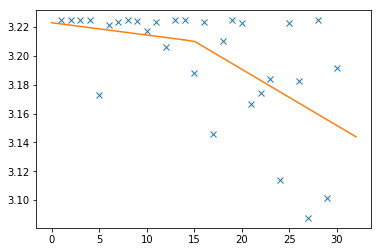

In [26]:
Testpwlf = False
if Testpwlf:  # this sounded good but was bad
    import pwlf

    x=np.arange(1,31)

    model = pwlf.PiecewiseLinFit(x, ytrain)

    breakpoints = model.fit(2,x_c=x[0:15],
                            y_c=np.ones(16)*max(ytrain[0:10]))  # or maybe    [0.0, 15.0, 32]
    #breakpoints = model.fit(2)
    model.fit_with_breaks(breakpoints)


    xd = np.linspace(1990, 2021, 100)
    xd = np.linspace(0, 32, 35)
    yd = model.predict(xd)  # call model on new data

    plt.plot(x, ytrain, 'x', label = 'data')
    plt.plot(xd, yd, label = 'Fit')
